In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv('../data/raw/realtor-data.zip.csv')


# EDA 

### 1. Basic Data Info



realtor-data.csv (2,226,382 entries)


brokered by (categorically encoded agency/broker)


status (Housing status - a. ready for sale or b. ready to build)

price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)


bed (# of beds)


bath (# of bathrooms)


acre_lot (Property / Land size in acres)


street (categorically encoded street address)


city (city name)


state (state name)


zip_code (postal code of the area)


house_size (house area/size/living space in square feet)


prev_sold_date (Previously sold date)

In [279]:
print(f"Shape of the dataset: {df.shape}")
print(f"\n The first 5 rows of the dataset {df.head()}")


Shape of the dataset: (2226382, 12)

 The first 5 rows of the dataset    brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3       Ponce  Puerto Rico     731.0      1800.0            NaN  
4    Mayaguez  Puerto Rico     680.0         NaN            NaN  


In [193]:
# Missing values
df.isna().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

### 2. Descriptive Statistics

In [21]:
print(f"Some info about the dataset: {df.info()}")
print(f"\n Description {df.describe()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB
Some info about the dataset: None

 Description         brokered_by         price           bed          bath      acre_lot  \
count  2.221849e+06  2.224841e+06  1.745065e+06  1.714611e+06  1.900793e+06   
mean   5.293989e+04  5.241955e+05  3.275841e+00  2.496440e+00  1.522303e+01   
std    3.064275e+04  2.138893e+06  1.567274e+00  1.652573e+00  7.628238e+02   
min    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  

In [249]:
# Looking at price

print(f"Average house price {df['price'].mean()}")
print(f"Median house price {df['price'].median()}")
print(f"Minimum price {df['price'].min()}")
print(f"Maximum price {df['price'].max()}")



Average house price 524195.5192906774
Median house price 325000.0
Minimum price 0.0
Maximum price 2147483600.0


In [4]:
# change acre to lot size
df['lot_sqft'] = df['acre_lot'] * 43560
# drop columns: brokered_by and street - Irrelavant
df.drop(columns= ['street', 'brokered_by', 'acre_lot'], inplace=True)
# Drop rows where price or state is missing
df = df.dropna(subset=['price', 'state'])
print(df.isna().sum())
df.head()


status                 0
price                  0
bed               480859
bath              510984
city                1404
state                  0
zip_code             296
house_size        567872
prev_sold_date    733248
lot_sqft          325134
dtype: int64


,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0
4,for_sale,65000.0,6.0,2.0,Mayaguez,Puerto Rico,680.0,NaN,NaN,2178.0


### Deal with Missing values first

In [282]:
df.columns

Index(['status', 'price', 'bed', 'bath', 'city', 'state', 'zip_code',
       'house_size', 'lot_sqft'],
      dtype='object')

In [5]:
columns = ['status', 'price', 'bed', 'bath',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date',
       'lot_sqft']
for i in columns:
    print(round(df[i].isna().sum() / len(df) * 100, 2))

0.0
0.0
21.61
22.97
0.06
0.0
0.01
25.52
32.96
14.61


In [6]:
def missing_percent(df, columns):
    """
    Calculate missng values in percent for each specified column

    Args:
        df: Dataframe - input DataFrame
        columns list - List of columns to check
    returns:
        dict: Dictionary with column name as keys and missing percentage
    """
    missing_percentage = {}
    
    for col in columns:
        percent = (df[col].isna().sum() / len(df)) * 100
        missing_percentage[col] = round((percent), 2)
        
    return missing_percentage

In [7]:
cols_to_check = ['status', 'price', 'bed', 'bath',
       'city', 'state', 'zip_code', 'house_size',
       'lot_sqft']

missing_values = missing_percent(df, cols_to_check)
missing_values

{'status': np.float64(0.0),
 'price': np.float64(0.0),
 'bed': np.float64(21.61),
 'bath': np.float64(22.97),
 'city': np.float64(0.06),
 'state': np.float64(0.0),
 'zip_code': np.float64(0.01),
 'house_size': np.float64(25.52),
 'lot_sqft': np.float64(14.61)}

In [8]:
for col, pct in missing_values.items():
    print(f"{col}: {pct}% missing")

status: 0.0% missing
price: 0.0% missing
bed: 21.61% missing
bath: 22.97% missing
city: 0.06% missing
state: 0.0% missing
zip_code: 0.01% missing
house_size: 25.52% missing
lot_sqft: 14.61% missing


In [9]:
# Dealing with missing values
def handle_missing_values(df, cols_to_check):
    df = df.copy()
    missing_values = missing_percent(df, cols_to_check)
    for col, pct in missing_values.items():
        if pct > 30:
            print(f"Dropping column '{col}' with {pct}% missing data.")
            df.drop(columns = [col], inplace=True)
        elif 0 < pct < 30:
            if df[col].dtype in ['float64', 'int64']:
                print(f"Filling numeric column {col} with median.")
                df[col].fillna(df[col].median, inplace=True)
            else:
                print("Filling Categorical column '{col}' with mode.")
                df[col].fillna(df[col].mode()[0], inplace=True)
    return df
        

    

In [10]:
df.columns

Index(['status', 'price', 'bed', 'bath', 'city', 'state', 'zip_code',
       'house_size', 'prev_sold_date', 'lot_sqft'],
      dtype='object')

In [11]:
cols_to_check = ['status', 'price', 'bed', 'bath',
       'city', 'state', 'zip_code', 'house_size',
       'lot_sqft']
clean_data=handle_missing_values(df, cols_to_check)


Filling numeric column bed with median.
Filling numeric column bath with median.
Filling Categorical column '{col}' with mode.


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_31781/4256703469.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method Series.median of 0          3.0
1          4.0
2          2.0
3          4.0
4          6.0
          ... 
2226377    4.0
2226378    3.0
2226379    6.0
2226380    2.0
2226381    5.0
Name: bed, Length: 2224833, dtype: float64>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[col].fillna(df[col].median, inplace=True)
/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_31781/4256703469.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method Series.median of 0          2.0
1          2.0
2          1.0
3          2.0
4          2.0
          ... 
2226377    2.0
2226378    2.0
2226379    3.0
2226380    1.0
2226381    3.0
Nam

Filling numeric column zip_code with median.
Filling numeric column house_size with median.
Filling numeric column lot_sqft with median.


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_31781/4256703469.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method Series.median of 0            601.0
1            601.0
2            795.0
3            731.0
4            680.0
            ...   
2226377    99354.0
2226378    99354.0
2226379    99354.0
2226380    99354.0
2226381    99354.0
Name: zip_code, Length: 2224833, dtype: float64>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[col].fillna(df[col].median, inplace=True)
/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_31781/4256703469.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method Series.median of 0           920.0
1          1527.0
2           748.0
3          1800.0
4             NaN
            ...  
2226377    

In [313]:
print(df.shape)

(2224833, 10)


 In prev_sold_date, the NaN values are not true missing values like errors or data loss.

Instead:

If prev_sold_date is NaN ➔ it simply means the house has never been sold before.

If prev_sold_date has a date ➔ it means the house was previously sold (resale property).

In [12]:
clean_data.isna().sum()

status                 0
price                  0
bed                    0
bath                   0
city                   0
state                  0
zip_code               0
house_size             0
prev_sold_date    733248
lot_sqft               0
dtype: int64

### Outliers

Mainly for numeric values

In [13]:
df['price'].min()

np.float64(0.0)

In [14]:
df[(df['price'] <= 10000)]

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft
4105,for_sale,10000.0,NaN,NaN,Florida,Massachusetts,1247.0,NaN,NaN,20037.6
4107,for_sale,10000.0,NaN,NaN,Florida,Massachusetts,1247.0,NaN,NaN,13068.0
4108,for_sale,9900.0,NaN,NaN,Florida,Massachusetts,1247.0,NaN,NaN,29185.2
4123,for_sale,10000.0,NaN,NaN,Becket,Massachusetts,1223.0,NaN,NaN,27007.2
4162,for_sale,9500.0,NaN,NaN,Becket,Massachusetts,1223.0,NaN,NaN,12196.8
...,...,...,...,...,...,...,...,...,...,...
2220629,sold,8500.0,NaN,NaN,Ephrata,Washington,98823.0,NaN,2021-11-19,55321.2
2220767,sold,7500.0,NaN,NaN,Ephrata,Washington,98823.0,NaN,2022-03-08,57063.6
2220813,sold,10000.0,NaN,NaN,Okanogan,Washington,98840.0,NaN,2022-04-22,10890.0
2221007,sold,1695.0,3.0,4.0,Leavenworth,Washington,98826.0,3910.0,2022-01-25,43560.0


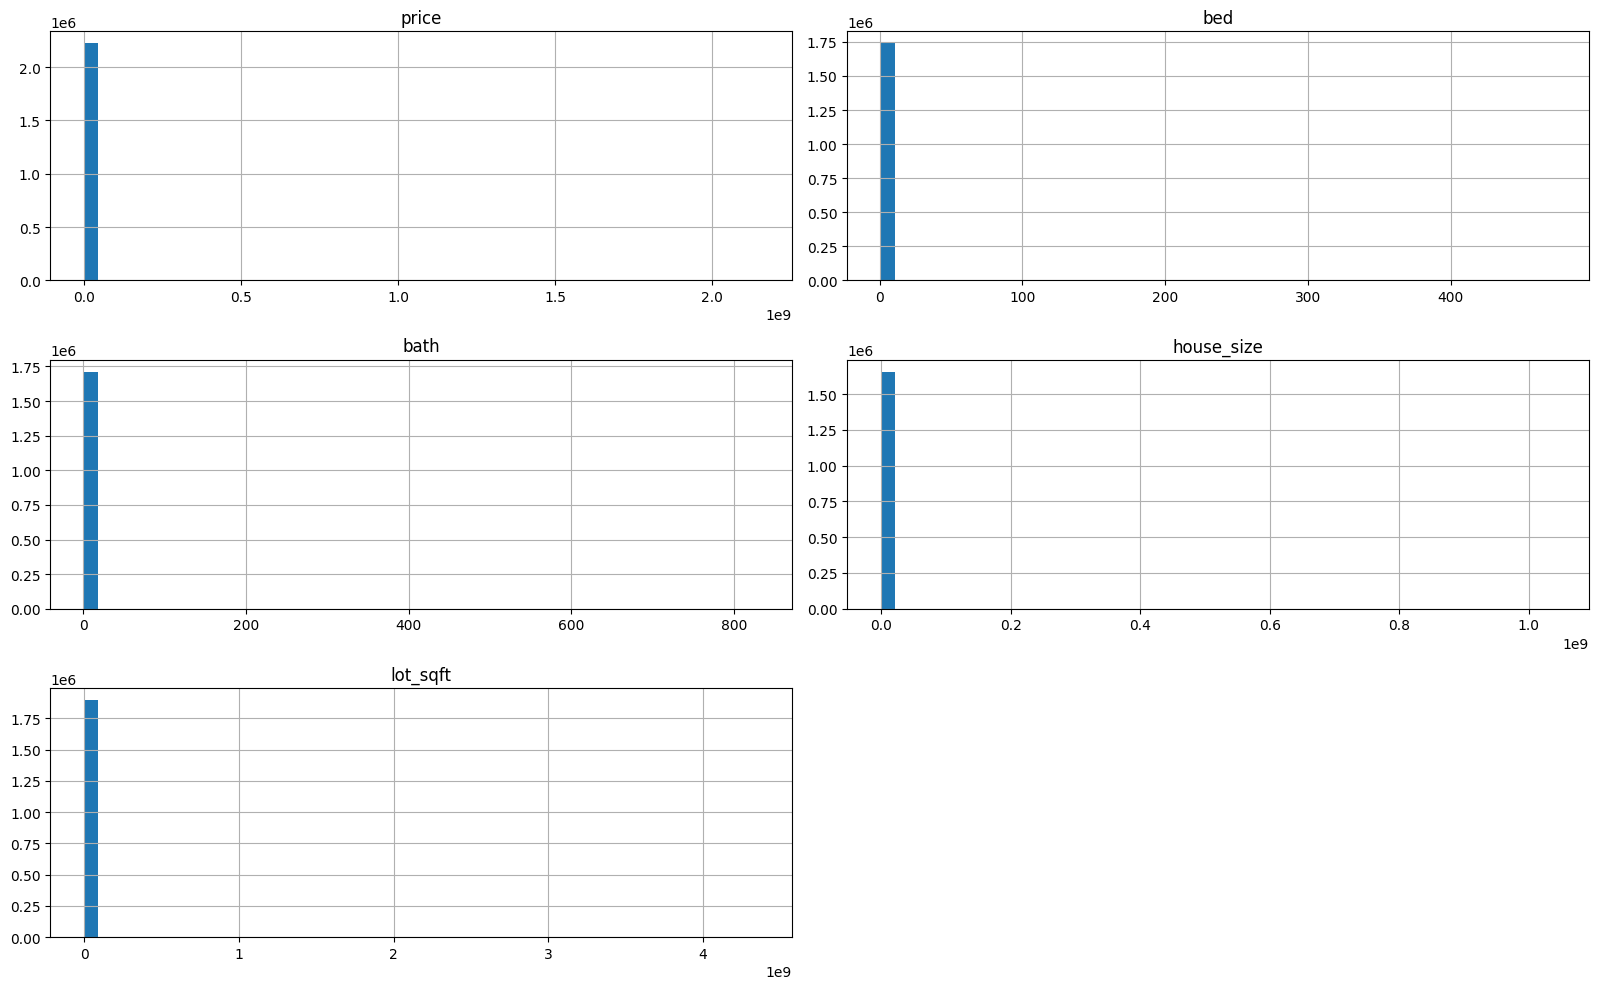

In [15]:
df[['price', 'bed', 'bath', 'house_size', 'lot_sqft']].hist(bins=50,
                figsize=(16, 10))
plt.tight_layout()
plt.show()

In [266]:
df.columns

Index(['status', 'price', 'bed', 'bath', 'city', 'state', 'zip_code',
       'house_size', 'prev_sold_date', 'lot_sqft'],
      dtype='object')

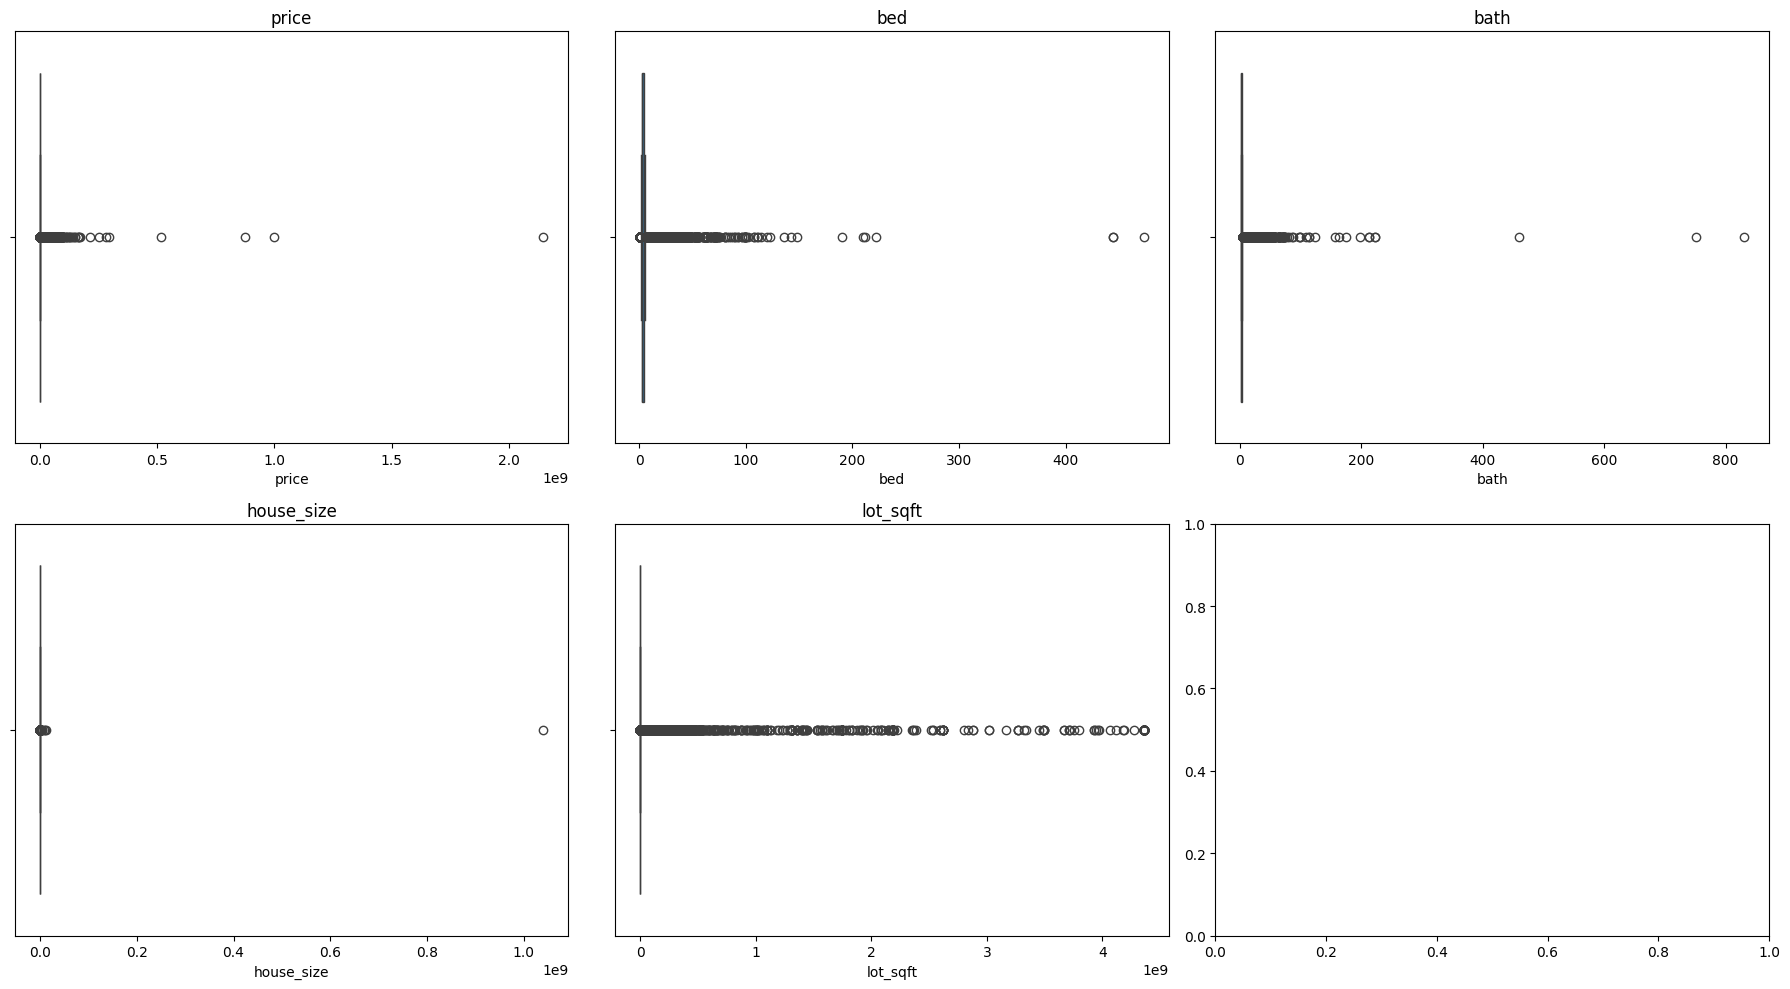

In [318]:
# Select columns for outliers
df_for_outliers=df[['price', 'bed', 'bath', 'house_size', 'lot_sqft']]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (18, 10))

axes = axes.flatten()

for idx, col in enumerate(df_for_outliers.columns):
    sns.boxplot(x=df_for_outliers[col], ax=axes[idx])
    axes[idx].set_title(col)
    
plt.tight_layout()
plt.show()

In [16]:
# Double clicking in each of the columns to see the extreme points - outliers
#Price - outliers
print("Price")
print("Price", df[df['price'] > 10000000].shape[0])  # about 4000 rows with price over 10 million
print(df[df['price'] < 10000].shape[0])

# Bed
print("\n Bed")
print(df[df['bed'] > 10].shape[0]) 
print(df[df['bed'] < 1].shape[0])

# Bath
print("\n bath")
print(df[df['bath'] > 10].shape[0]) 
print(df[df['bath'] < 1].shape[0])

# house_size sqft
print("\n house_size")
print(df[df['house_size'] > 15000].shape[0]) 
print(df[df['house_size'] < 100].shape[0]) 



# lot_sqft
print("\n lot_sqft")
print(df[df['lot_sqft'] > 1000000].shape[0]) 
print(df[df['lot_sqft'] < 100].shape[0])




Price
Price 3996
19270

 Bed
3728
0

 bath
2300
0

 house_size
1529
1

 lot_sqft
67954
2225


In [17]:
# Drop rows with crazy values
df_cleaned = clean_data[
    (df['price'] >= 10000) & (df['price'] <= 10000000) &
    (df['bed'] <= 10) &
    (df['bath'] <= 10) &
    (df['house_size'] >= 100) & (df['house_size'] <= 15000) &
    (df['lot_sqft'] >= 100) & (df['lot_sqft'] <= 1000000)
]
df_cleaned.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0
5,for_sale,179000.0,4.0,3.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6


In [369]:
df_cleaned.shape

(1335704, 10)

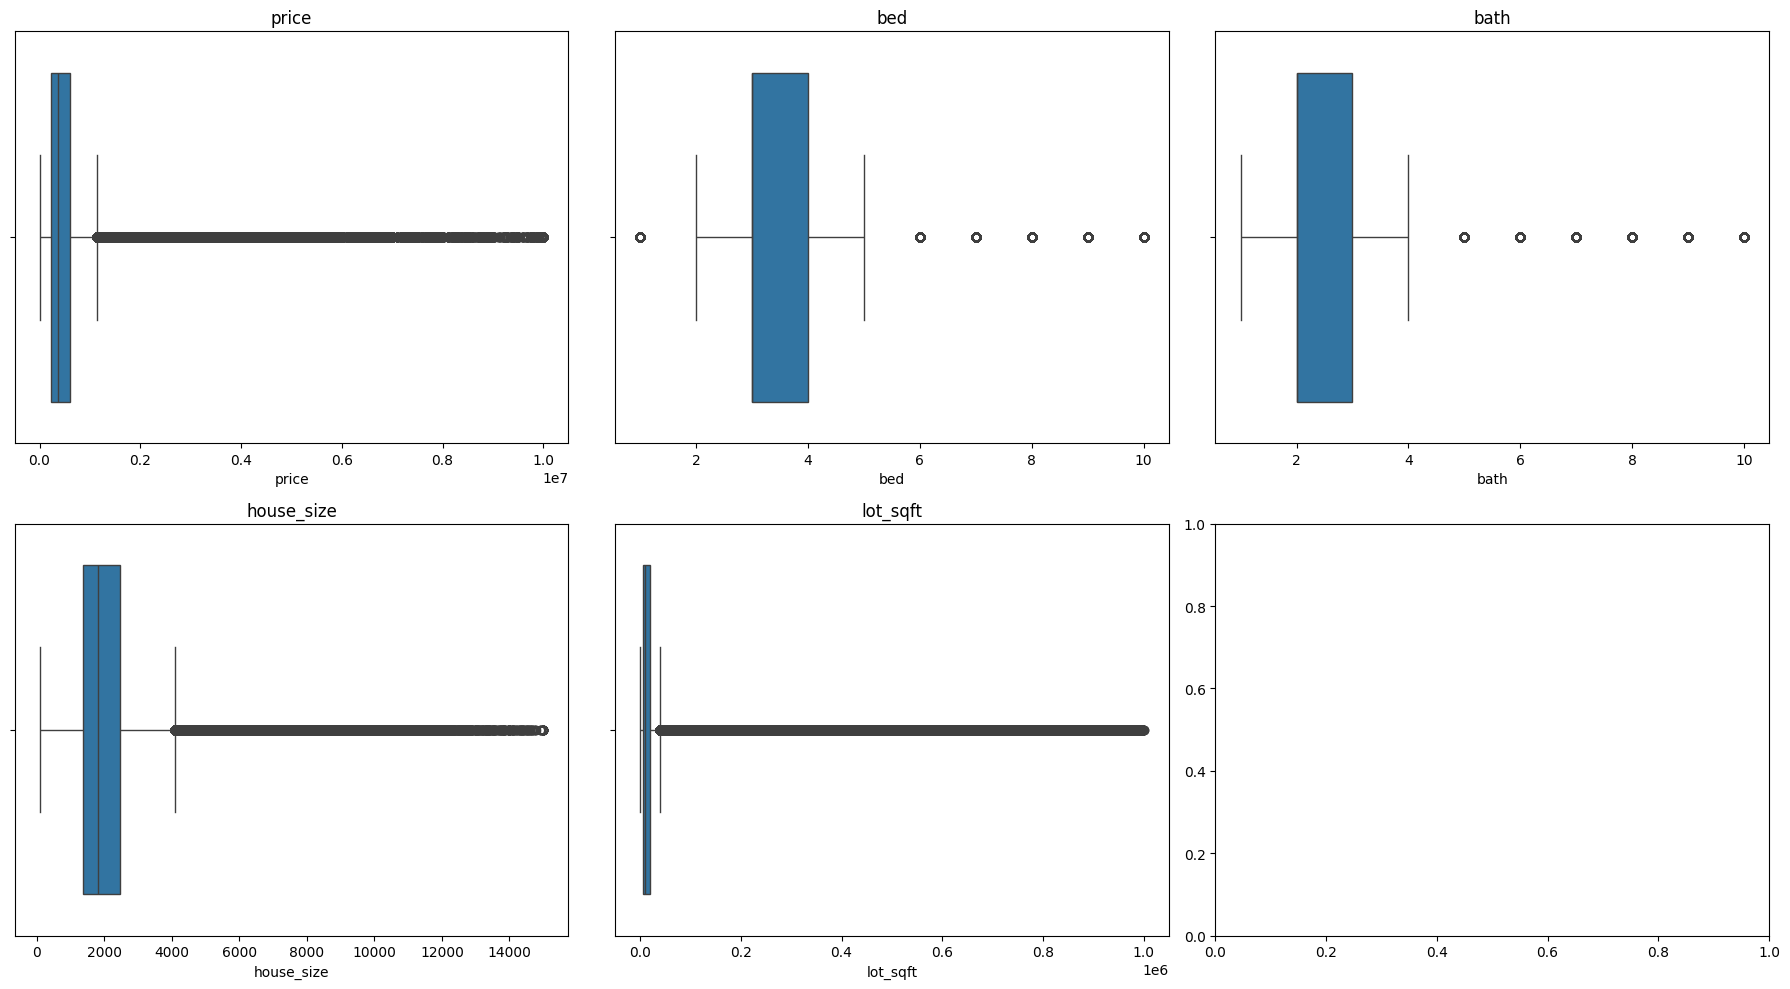

In [18]:
# Select columns for outliers - replottig after fixing the outliers
df_for_outliers=df_cleaned[['price', 'bed', 'bath', 'house_size', 'lot_sqft']]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (18, 10))

axes = axes.flatten()

for idx, col in enumerate(df_for_outliers.columns):
    sns.boxplot(x=df_for_outliers[col], ax=axes[idx])
    axes[idx].set_title(col)
    
plt.tight_layout()
plt.show()

### Feature Engineering 

1. For Exploration
2. Then for Modeling

In [19]:
data_for_exploring = df_cleaned.copy()

In [20]:
data_for_exploring.shape

(1335704, 10)

In [21]:
data_for_exploring['price_per_sqft'] = data_for_exploring['price'] / data_for_exploring['house_size']
data_for_exploring['price_per_sqft']

0          114.130435
1           52.390308
2           89.572193
3           80.555556
5           71.031746
              ...    
2226377     99.972222
2226378    216.584158
2226379         137.5
2226380    192.818864
2226381      160.4426
Name: price_per_sqft, Length: 1335704, dtype: object

In [22]:
data_for_exploring.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,price_per_sqft
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2,114.130435
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8,52.390308
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0,89.572193
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0,80.555556
5,for_sale,179000.0,4.0,3.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6,71.031746


In [23]:
data_for_exploring['status'].value_counts()

status
for_sale    732107
sold        603597
Name: count, dtype: int64

In [24]:
data_for_exploring['bed_bath_ratio'] = data_for_exploring['bed'] / data_for_exploring['bath']
data_for_exploring.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,price_per_sqft,bed_bath_ratio
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2,114.130435,1.5
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8,52.390308,2.0
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0,89.572193,2.0
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0,80.555556,2.0
5,for_sale,179000.0,4.0,3.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6,71.031746,1.333333


In [25]:
data_for_exploring['was_sold_before'] = data_for_exploring['prev_sold_date'].notnull().astype(int)
data_for_exploring.head()


,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,price_per_sqft,bed_bath_ratio,was_sold_before
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2,114.130435,1.5,0
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8,52.390308,2.0,0
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0,89.572193,2.0,0
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0,80.555556,2.0,0
5,for_sale,179000.0,4.0,3.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6,71.031746,1.333333,0


In [26]:
data_for_exploring.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1335704 entries, 0 to 2226381
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   status           1335704 non-null  object 
 1   price            1335704 non-null  float64
 2   bed              1335704 non-null  object 
 3   bath             1335704 non-null  object 
 4   city             1335704 non-null  object 
 5   state            1335704 non-null  object 
 6   zip_code         1335704 non-null  object 
 7   house_size       1335704 non-null  object 
 8   prev_sold_date   1075765 non-null  object 
 9   lot_sqft         1335704 non-null  object 
 10  price_per_sqft   1335704 non-null  object 
 11  bed_bath_ratio   1335704 non-null  object 
 12  was_sold_before  1335704 non-null  int64  
dtypes: float64(1), int64(1), object(11)
memory usage: 142.7+ MB


In [27]:
# Convert numeric columns that are wrongly stored as object
cols_to_float = ['price', 'bed', 'bath', 'house_size', 'lot_sqft', 'price_per_sqft']

for col in cols_to_float:
    data_for_exploring[col] = pd.to_numeric(data_for_exploring[col], errors='coerce')

In [28]:
# 3. Log transformations for skewed features
for col in ['price', 'house_size', 'lot_sqft']:
    data_for_exploring[f'log_{col}'] = np.log1p(data_for_exploring[col])

In [29]:
data_for_exploring.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,price_per_sqft,bed_bath_ratio,was_sold_before,log_price,log_house_size,log_lot_sqft
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2,114.130435,1.5,0,11.561725,6.825460,8.561822
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8,52.390308,2.0,0,11.289794,7.331715,8.156453
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0,89.572193,2.0,0,11.112463,6.618739,8.784928
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0,80.555556,2.0,0,11.884496,7.496097,8.379539
5,for_sale,179000.0,4.0,3.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6,71.031746,1.333333,0,12.095147,7.832411,9.905416


In [30]:
data_for_exploring['city'].value_counts()

city
Houston            19475
Tucson              7860
Phoenix             7554
Dallas              7481
Philadelphia        7306
                   ...  
Nile Township          1
Willshire              1
Paxton Township        1
Pitsburg               1
Jack                   1
Name: count, Length: 16799, dtype: int64

In [31]:
# 6. City listing density (popularity of city)
city_counts = data_for_exploring['city'].value_counts()
data_for_exploring['city_listing_count'] = data_for_exploring['city'].map(city_counts)

In [32]:
le = LabelEncoder()
data_for_exploring['zip_code_encoded'] = le.fit_transform(data_for_exploring['zip_code'].astype(str))

In [33]:
data_for_exploring[['price_per_sqft', 'bed_bath_ratio', 'log_price', 'log_house_size', 'was_sold_before', 'city_listing_count']].describe()


,price_per_sqft,log_price,log_house_size,was_sold_before,city_listing_count
count,1.335704e+06,1.335704e+06,1.335704e+06,1.335704e+06,1.335704e+06
mean,2.550425e+02,1.283653e+01,7.522650e+00,8.053918e-01,1.453260e+03
std,2.191286e+02,7.995803e-01,4.537024e-01,3.958990e-01,2.786619e+03
min,1.846381e+00,9.210440e+00,4.615121e+00,0.000000e+00,1.000000e+00
25%,1.399333e+02,1.237358e+01,7.214504e+00,1.000000e+00,1.520000e+02
50%,1.962993e+02,1.283468e+01,7.499423e+00,1.000000e+00,4.640000e+02
75%,2.918028e+02,1.330302e+01,7.807510e+00,1.000000e+00,1.461000e+03
max,2.180000e+04,1.611810e+01,9.615872e+00,1.000000e+00,1.947500e+04


### 1. Histograms: Distribution of Key Numerical Features

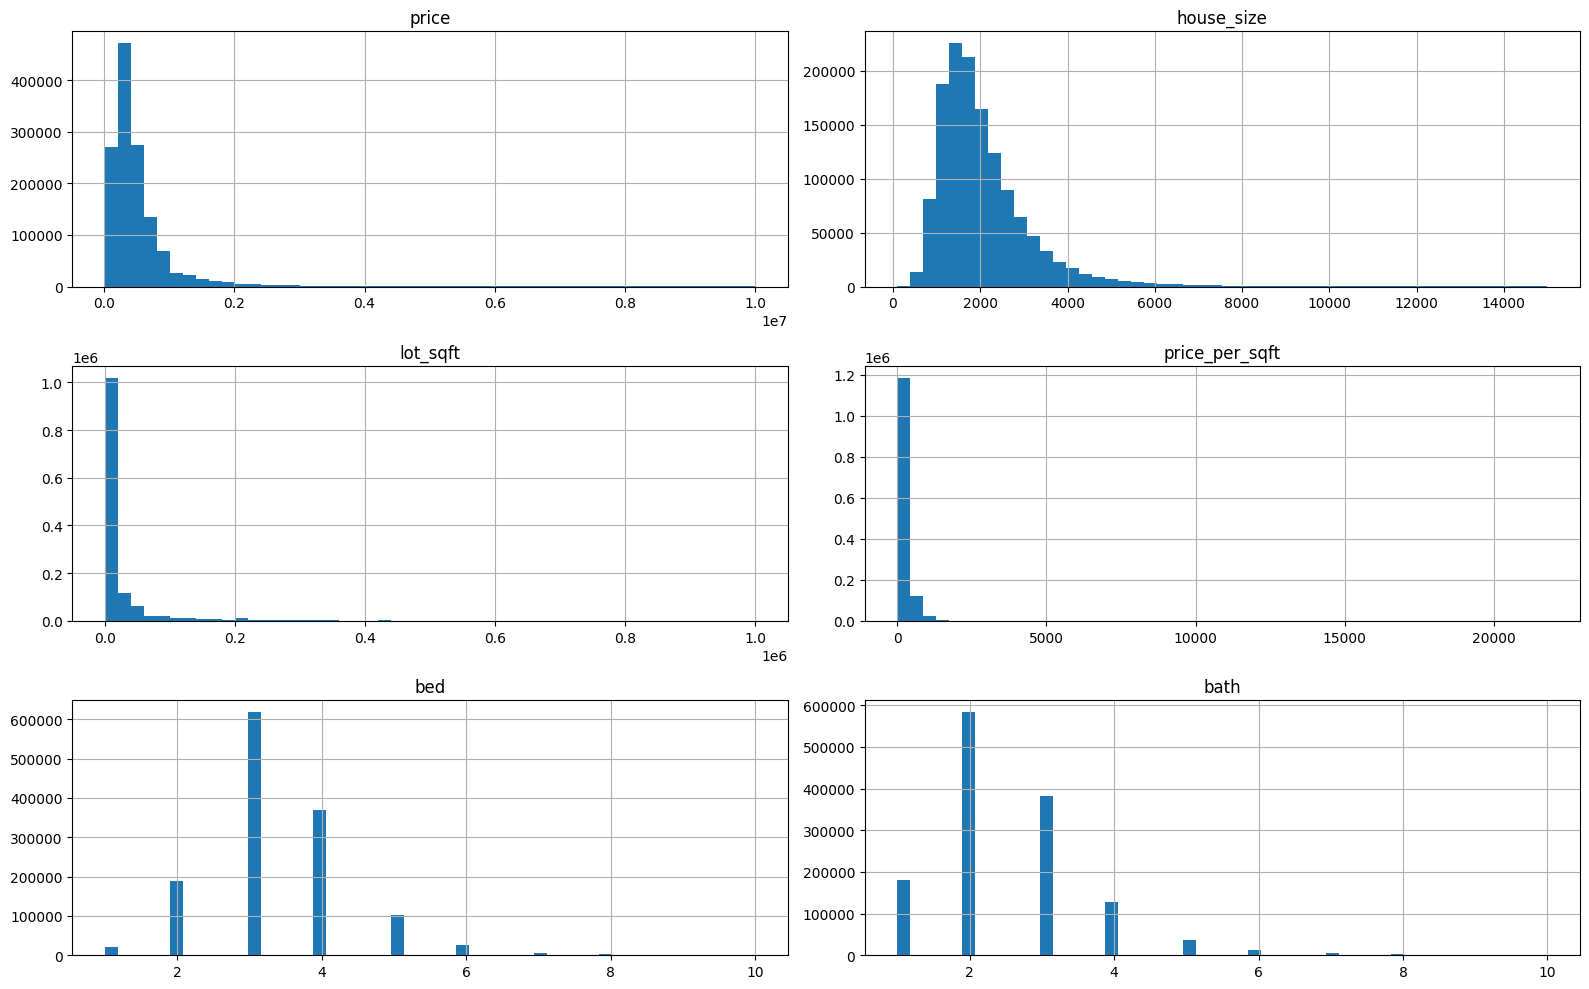

In [34]:
data_for_exploring[['price', 'house_size', 'lot_sqft', 'price_per_sqft', 'bed', 'bath']].hist(figsize=(16, 10), bins=50)
plt.tight_layout()
plt.show()

### 2. Boxplots: Detecting Outliers

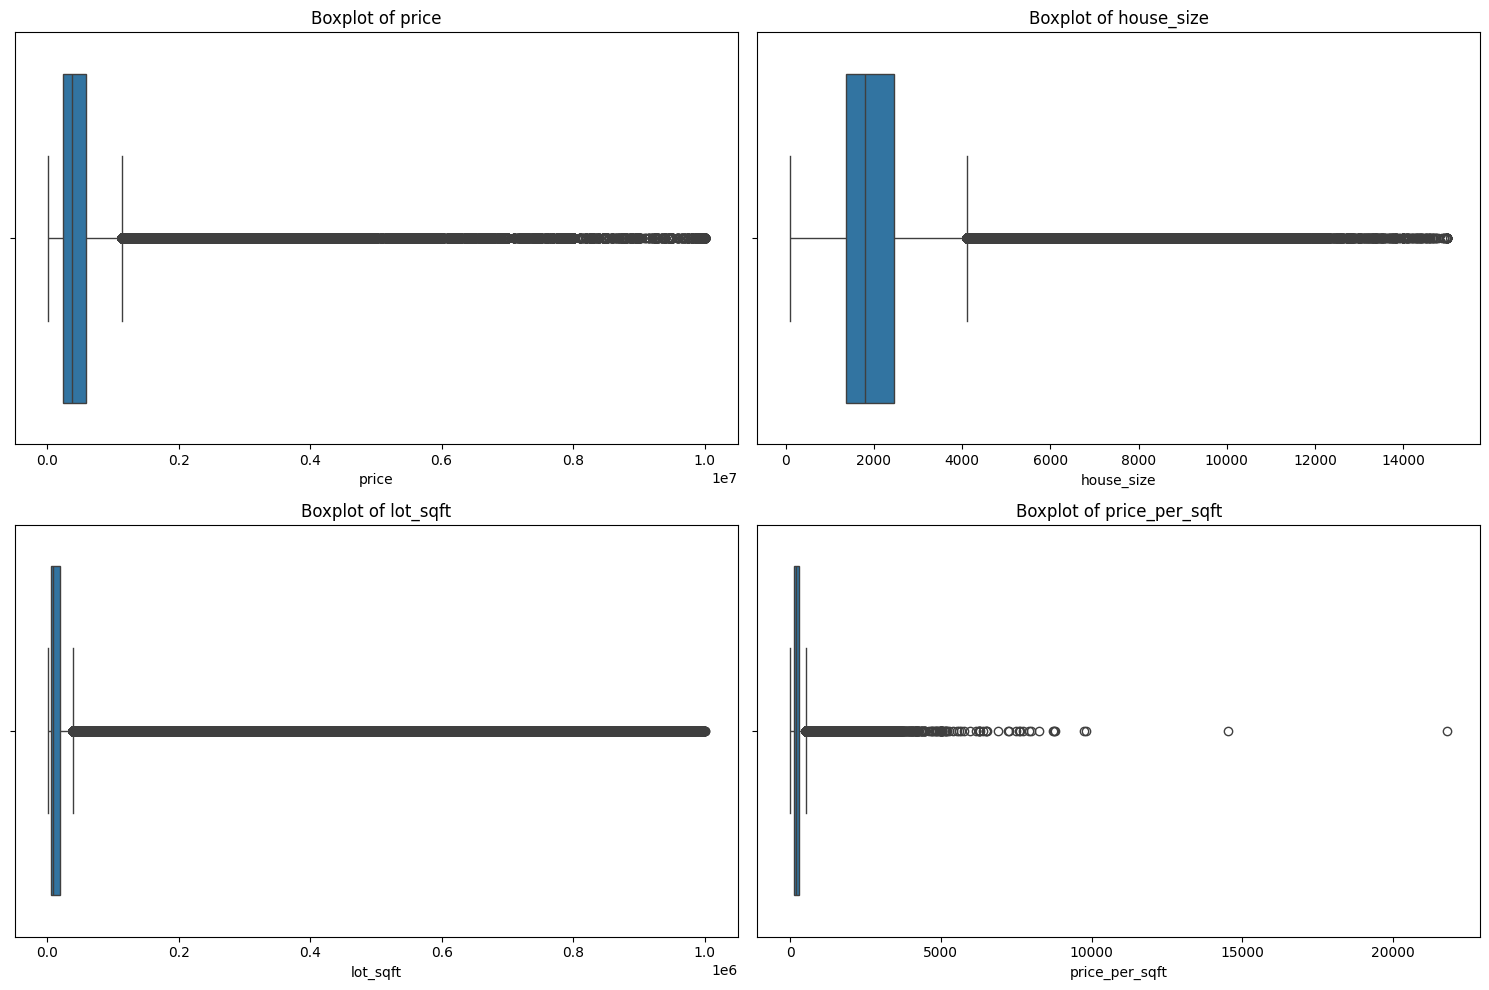

In [35]:
features = ['price', 'house_size', 'lot_sqft', 'price_per_sqft']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(features):
    sns.boxplot(x=data_for_exploring[col], ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

### 3. Correlation Heatmap

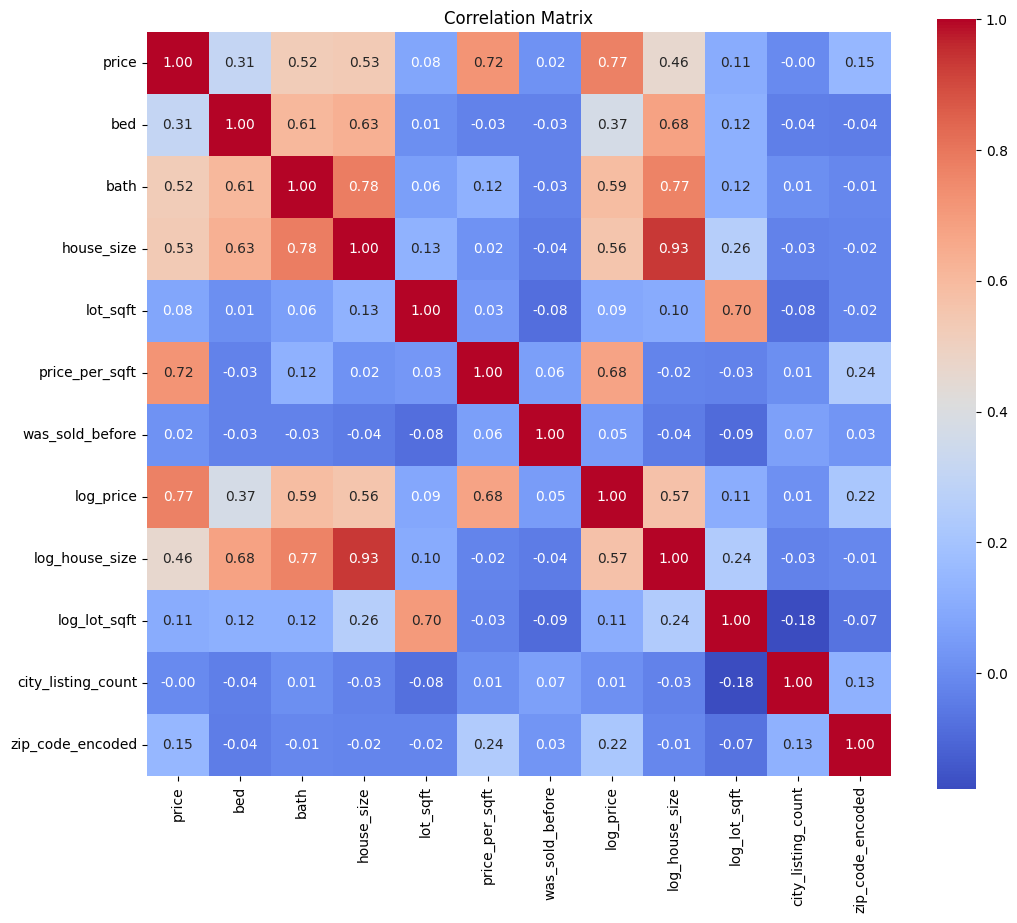

In [36]:
# Select only numerical features
numeric_cols = data_for_exploring.select_dtypes(include='number')

# Correlation
corr = numeric_cols.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

### 4. Scatter Plot: House Size vs Price (Colored by Number of Beds)

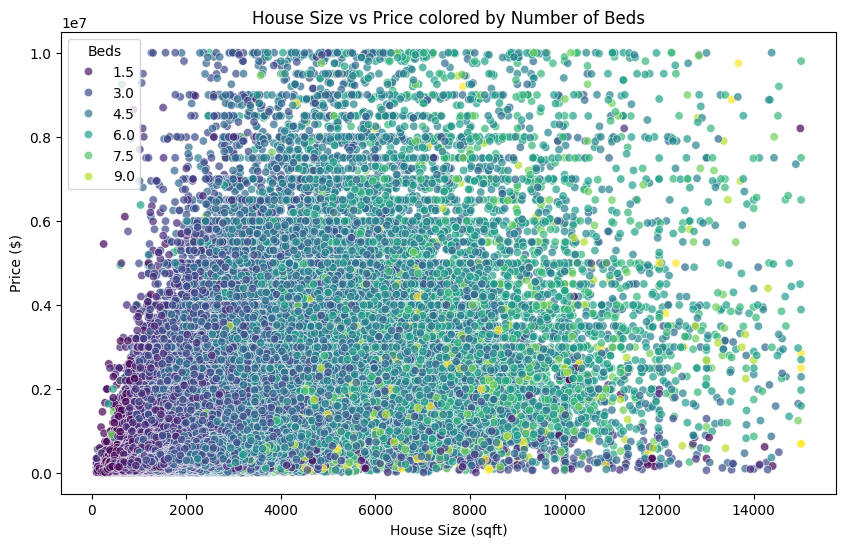

In [345]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='house_size', y='price', hue='bed', data=data_for_exploring, palette='viridis', alpha=0.7)
plt.title('House Size vs Price colored by Number of Beds')
plt.xlabel('House Size (sqft)')
plt.ylabel('Price ($)')
plt.legend(title='Beds', loc='upper left')
plt.show()


### 5. Bar Plot: Top 10 States by Number of Listings

/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_17063/2886316494.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette='mako')


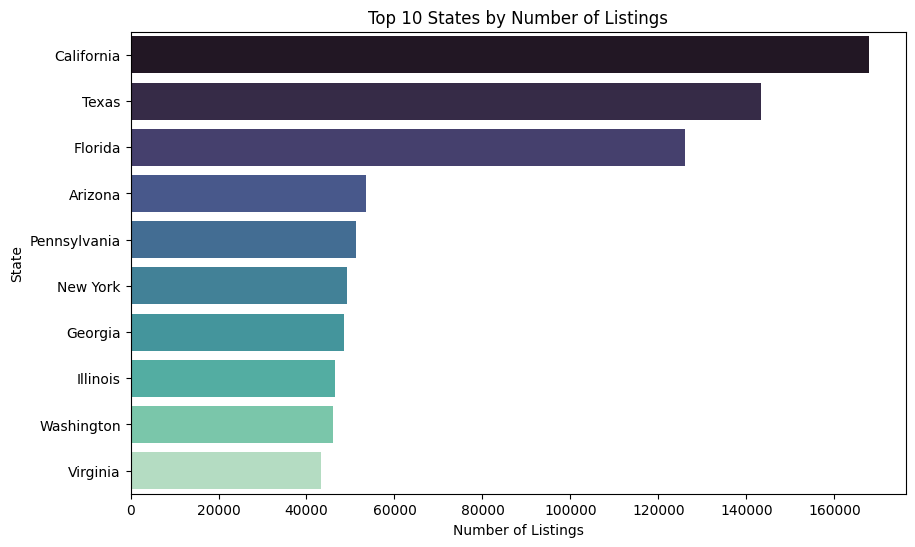

In [346]:
top_states = data_for_exploring['state'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_states.values, y=top_states.index, palette='mako')
plt.title('Top 10 States by Number of Listings')
plt.xlabel('Number of Listings')
plt.ylabel('State')
plt.show()

### 6: Listings by City

/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_17063/1387707762.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='rocket')


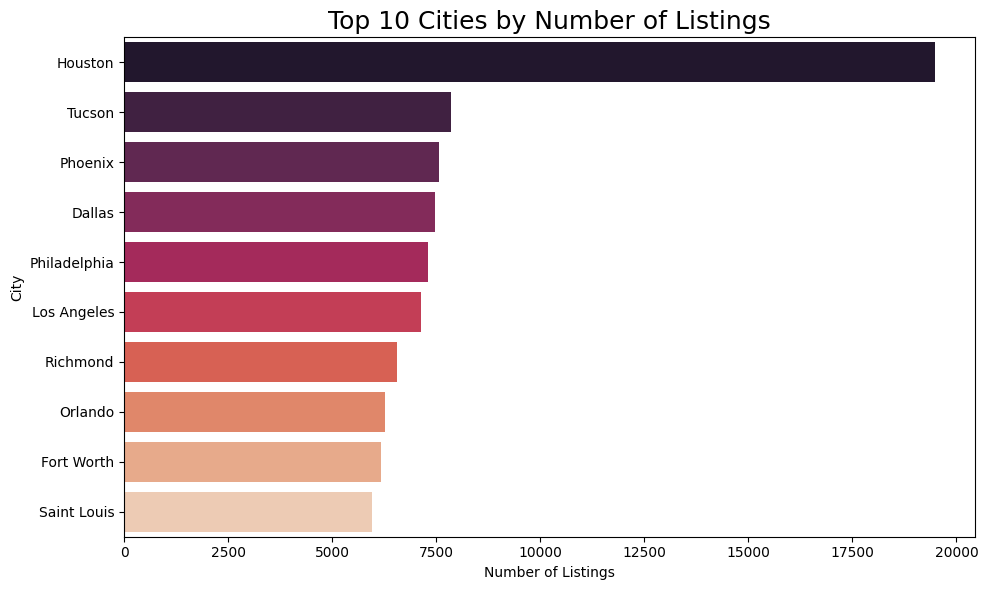

In [350]:
top_cities = data_for_exploring['city'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette='rocket')
plt.title('Top 10 Cities by Number of Listings', fontsize=18)
plt.xlabel('Number of Listings')
plt.ylabel('City')
plt.tight_layout()
plt.show()

In [351]:
data_for_exploring.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,price_per_sqft,bed_bath_ratio,was_sold_before,log_price,log_house_size,log_lot_sqft,city_listing_count,zip_code_encoded
0,for_sale,105000.0,3.0,2.0,Adjuntas,Puerto Rico,601.0,920.0,NaN,5227.2,114.130435,1.5,0,11.561725,6.825460,8.561822,2,16331
1,for_sale,80000.0,4.0,2.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN,3484.8,52.390308,2.0,0,11.289794,7.331715,8.156453,2,16331
2,for_sale,67000.0,2.0,1.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN,6534.0,89.572193,2.0,0,11.112463,6.618739,8.784928,12,22660
3,for_sale,145000.0,4.0,2.0,Ponce,Puerto Rico,731.0,1800.0,NaN,4356.0,80.555556,2.0,0,11.884496,7.496097,8.379539,50,20443
5,for_sale,179000.0,4.0,3.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN,20037.6,71.031746,1.333333,0,12.095147,7.832411,9.905416,14,16783


In [370]:
df_cleaned['city'].value_counts()

city
Houston            19475
Tucson              7860
Phoenix             7554
Dallas              7481
Philadelphia        7306
                   ...  
Nile Township          1
Willshire              1
Paxton Township        1
Pitsburg               1
Jack                   1
Name: count, Length: 16799, dtype: int64

In [37]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1335704 entries, 0 to 2226381
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   status          1335704 non-null  object 
 1   price           1335704 non-null  float64
 2   bed             1335704 non-null  object 
 3   bath            1335704 non-null  object 
 4   city            1335704 non-null  object 
 5   state           1335704 non-null  object 
 6   zip_code        1335704 non-null  object 
 7   house_size      1335704 non-null  object 
 8   prev_sold_date  1075765 non-null  object 
 9   lot_sqft        1335704 non-null  object 
dtypes: float64(1), object(9)
memory usage: 112.1+ MB


In [38]:
df_cleaned = df_cleaned.copy()

In [39]:
# Convert numeric columns that are wrongly stored as objec
# --- 1. Convert true numeric columns (price, lot_sqft, house_size) ---
numeric_cols = ['price', 'lot_sqft', 'house_size']
for col in numeric_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')


# --- 2. Convert bed and bath to proper integer (nullable Int64) ---
# (This avoids making them floats unnecessarily)
for col in ['bed', 'bath']:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').astype('Int64')



In [40]:
# --- 3. City and State ---
# Treat these as categories
df_cleaned['city'] = df_cleaned['city'].astype('category')
df_cleaned['state'] = df_cleaned['state'].astype('category')
df_cleaned['zip_code'] = pd.to_numeric(df_cleaned['zip_code'], errors='coerce').astype('Int64')

In [43]:
le_city = LabelEncoder()
le_state = LabelEncoder()

# Apply encoding
df_cleaned['city_encoded'] = le_city.fit_transform(df_cleaned['city'].astype(str))
df_cleaned['state_encoded'] = le_state.fit_transform(df_cleaned['state'].astype(str))

In [44]:
df_cleaned.head()

,status,price,bed,bath,city,state,zip_code,house_size,prev_sold_date,lot_sqft,city_encoded,state_encoded
0,for_sale,105000.0,3,2,Adjuntas,Puerto Rico,601,920.0,NaN,5227.2,62,40
1,for_sale,80000.0,4,2,Adjuntas,Puerto Rico,601,1527.0,NaN,3484.8,62,40
2,for_sale,67000.0,2,1,Juana Diaz,Puerto Rico,795,748.0,NaN,6534.0,7367,40
3,for_sale,145000.0,4,2,Ponce,Puerto Rico,731,1800.0,NaN,4356.0,11985,40
5,for_sale,179000.0,4,3,San Sebastian,Puerto Rico,612,2520.0,NaN,20037.6,13281,40


### Choose X and y

In [45]:
X = df_cleaned[['bed', 'bath', 'city_encoded', 'state_encoded', 'house_size', 'lot_sqft']]
y = df_cleaned['price']


In [389]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [391]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(1068563, 6)
(1068563,)
(267141, 6)
(267141,)


In [392]:
# model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [402]:
# predict
y_predict = lr.predict(X_test)

In [396]:
# Evaluate
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print(f"Test MSE: {mse:.2f}")
print(f"Test R^2: {r2:.2f}")

Test MSE: 257046607250.56
Test R^2: 0.35


In [404]:
# RandomForest

rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42)
rf.fit(X_train, y_train)



RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42)

In [405]:
y_pred = rf.predict(X_test)

In [406]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R^2: {r2:.2f}")

Test MSE: 154679125638.31
Test R^2: 0.61


In [425]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=9,
    min_child_weight=5,
    random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [426]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R^2: {r2:.2f}")

Test MSE: 124146037970.97
Test R^2: 0.68


In [410]:
# Define the model
xgb = XGBRegressor(random_state=42)

# Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 12],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,   # Number of different combos to try
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best Model
best_xgb = random_search.best_estimator_

# Predict
y_pred_best = best_xgb.predict(X_test)


mse = mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print(f"Optimized Test MSE: {mse:.2f}")
print(f"Optimized Test R²: {r2:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, min_child_weight=5, subsample=0.8; total time=  17.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, min_child_weight=5, subsample=0.8; total time=  18.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, min_child_weight=5, subsample=0.8; total time=  18.6s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.7; total time=  21.3s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.7; total time=  21.5s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.7; total time=  21.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=12, min_child_weight=1, subsample=0.9; total time=  22.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=12, min_child_weight=1, subsample=0.9; total tim

/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_17063/2663201806.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


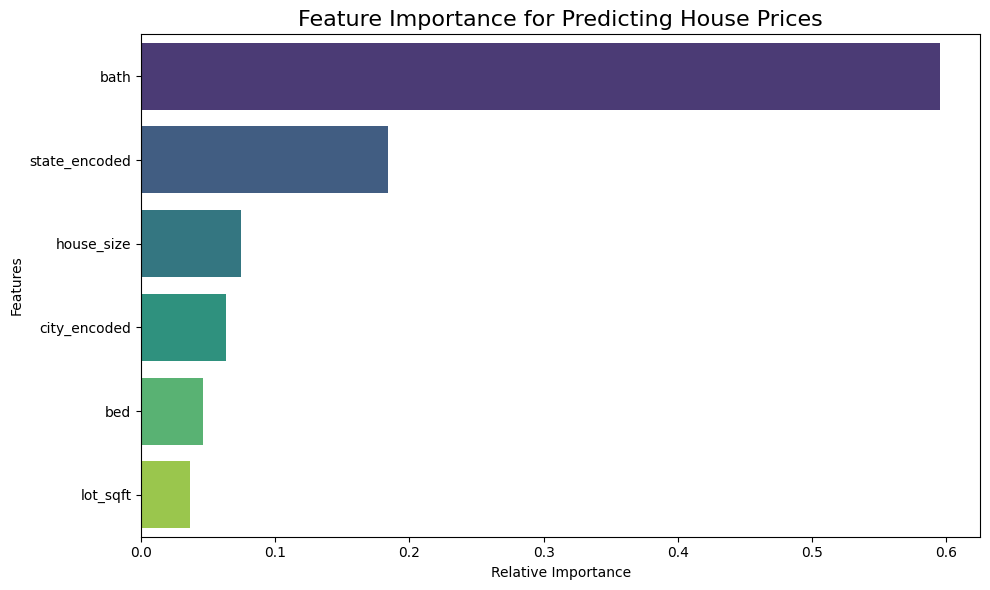

In [427]:

# Get feature importance
importance = best_xgb.feature_importances_
features = X_train.columns

# Create a dataframe for better plotting
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Predicting House Prices', fontsize=16)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [47]:
path = "../data/processed/data.csv"
df_cleaned.to_csv(path, index=False)
